In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import matplotlib
matplotlib.use('Agg')
from orphics import maps,io,cosmology,stats
from pixell import enmap
import numpy as np
from szar import foregrounds as fg
import os,sys

In [37]:
class ArrayGen(object):
      def __init__(self,shape,wcs,theory,freqs,beams,noises,lknees,alphas,ellmins,ellmaxes):

          fgn = fg.fgNoises(cosmology.defaultConstants,ksz_file='/home/msyriac/repos/szar/input/ksz_BBPS.txt',
                    ksz_p_file='/home/msyriac/repos/szar/input/ksz_p_BBPS.txt',
                    tsz_cib_file='/home/msyriac/repos/szar/input/sz_x_cib_template.txt',
                    ksz_battaglia_test_csv=None,
                    tsz_battaglia_template_csv="/home/msyriac/repos/szar/input/sz_template_battaglia.csv",
                    rs_template="/home/msyriac/repos/szar/input/fiducial_scalCls_lensed_5_5.txt",
                    rsx_template="/home/msyriac/repos/szar/input/fiducial_scalCls_lensed_1_5.txt",
                    components=['tsz','cibp','cibc','radps'],lmax=20000)
        
          self.modlmap = enmap.modlmap(shape,wcs)
          modlmap = self.modlmap
          self.fgn = fgn
          lmax = self.modlmap.max()
          ells = np.arange(0,lmax,1)
          ps_cmb = theory.lCl('TT',modlmap).reshape((1,1,shape[-2],shape[-1]))
          self.ps_cmb = ps_cmb
          ps_y = fgn.tsz_template(ells).reshape((1,1,ells.size))*self.fgn.c['A_tsz']*2.*np.pi*np.nan_to_num(1./ells/(ells+1.))
          ps_cibp = (fgn.c['A_cibp'] * ((ells/fgn.c['ell0sec'])) ** 2.0 *2.*np.pi*np.nan_to_num(1./ells/(ells+1.))).reshape((1,1,ells.size))
          ps_cibc = (fgn.c['A_cibc'] * ((ells/fgn.c['ell0sec'])) ** (2.-fgn.c['n_cib']) * \
                  2.*np.pi*np.nan_to_num(1./ells/(ells+1.))).reshape((1,1,ells.size))
          ps_radps = (fgn.c['A_ps'] * ((ells/fgn.c['ell0sec'])) ** 2 * \
                  2.*np.pi*np.nan_to_num(1./ells/(ells+1.))).reshape((1,1,ells.size))
          self.cgen = maps.MapGen(shape[-2:],wcs,ps_cmb)
          self.tgen = maps.MapGen(shape[-2:],wcs,ps_y)
          self.cibpgen = maps.MapGen(shape[-2:],wcs,ps_cibp)
          self.cibcgen = maps.MapGen(shape[-2:],wcs,ps_cibc)
          self.radpsgen = maps.MapGen(shape[-2:],wcs,ps_radps)
          self.shape = shape ; self.wcs = wcs
          self.freqs = freqs
          self.kbeams = []
          self.ngens = []
          self.n2ds = []
          for ai,nu in enumerate(self.freqs):
              self.kbeams.append(maps.gauss_beam(fwhm=beams[ai],ell=self.modlmap))
              n2d = cosmology.noise_func(self.modlmap,0,noises[ai],lknee=lknees[ai],alpha=alphas[ai],dimensionless=False,TCMB=2.7255e6)
              n2d[modlmap<ellmins[ai]] = 0
              n2d[modlmap>ellmaxes[ai]] = 0
              n2dmod = n2d.copy()
              n2dmod[modlmap>ellmaxes[ai]] =  1e90
              n2dmod[modlmap<ellmins[ai]] =  1e90
              self.n2ds.append(n2dmod.copy())
              ps_noise = n2d.reshape((1,1,shape[-2],shape[-1]))
              self.ngens.append(maps.MapGen(shape[-2:],wcs,ps_noise))
          self.ellmins = ellmins
          self.ellmaxes = ellmaxes
          
      def get_maps(self,seed=None):
          cmb = self.cgen.get_map(seed=(1,seed) if seed is not None else None)
          y = self.tgen.get_map(seed=(2,seed) if seed is not None else None)
          cibp = self.cibpgen.get_map(seed=(4,seed) if seed is not None else None)
          cibc = self.cibcgen.get_map(seed=(5,seed) if seed is not None else None)
          radps = self.radpsgen.get_map(seed=(6,seed) if seed is not None else None)
          observed = []
          for ai,nu in enumerate(self.freqs):
              tsz = self.fgn.tSZ_nu(nu) * y
              tsz += (self.fgn.cib_nu(nu) * cibp + self.fgn.cib_nu(nu) * cibc + self.fgn.rad_ps_nu(nu) * radps )
              observed.append(self._filter(self._beam(cmb+tsz,ai)+self._noise(ai,seed),ai))
          observed = np.stack(observed)
          return cmb,y,observed
      def _beam(self,imap,ai):
          return maps.filter_map(imap,self.kbeams[ai])
      def _noise(self,ai,seed=None):
          return self.ngens[ai].get_map(seed=(3,seed) if seed is not None else None)
      def _filter(self,imap,ai):
          kmask = maps.mask_kspace(self.shape,self.wcs,lmin=self.ellmins[ai],lmax=self.ellmaxes[ai])
          return maps.filter_map(imap,kmask)
      
      def get_cov(self):
          pass

deg = 5.
px = 1.0
shape,wcs = maps.rect_geometry(width_deg=deg,px_res_arcmin=px)
theory = cosmology.default_theory()

# ACT + Planck III
#freqs = [150,150,150,150,150,90,143,217,353]
#beams = np.array([1.5,1.5,1.5,1.5,1.5,2.3,7.,5.,5.])
#noises = [30.,30.,30.,30.,20.,15.,43.,66.,200.]
#lknees = [3000.]*5 + [1000.] + [0.]*3
#alphas = [-4.]*6 + [1.]*3
#ellmins = [300]*6 + [2]*3
#ellmaxes = [6000]*6 + [6000]*3


# ACT + Planck I
#freqs = [150,150,150,150,150,90,70,100,143,217,353]
#beams = np.array([1.5,1.5,1.5,1.5,1.5,2.3,14.,10.,7.,5.,5.])
#noises = [30.,30.,30.,30.,20.,15.,137.,65.,43.,66.,200.]
#lknees = [3000.]*5 + [1000.] + [0.]*5
#alphas = [-4.]*6 + [1.]*5
#ellmins = [300]*6 + [2]*5
#ellmaxes = [2000]*6 + [2000]*5


# ACT + Planck II
freqs = [150,150,150,150,150,90,100,143,217,353]
beams = np.array([1.5,1.5,1.5,1.5,1.5,2.3,10.,7.,5.,5.])
noises = [30.,30.,30.,30.,20.,15.,65.,43.,66.,200.]
lknees = [3000.]*5 + [1000.] + [0.]*4
alphas = [-4.]*6 + [1.]*4
ellmins = [300]*6 + [2]*4
ellmaxes = [3500]*6 + [3500]*4

# ACT
#freqs = [150,150,150,150,150,90]
#beams = np.array([1.5,1.5,1.5,1.5,1.5,2.3])
#noises = [20.,20.,20.,20.,15.,20.]
#lknees = [3000.]*5 + [1000.]
#alphas = [-4.]*6 
#ellmins = [300]*6 
#ellmaxes = [6000]*6 

# Planck
#freqs = [70,100,143,217,353]
#beams = np.array([14.,10.,7.,5.,5.])
#noises = [137.,65.,43.,66.,200.]
#lknees = [0.]*5
#alphas = [1.]*5
#ellmins = [2]*5
#ellmaxes = [3000]*5



assert len(freqs)==len(beams)==len(noises)==len(lknees)==len(alphas)
pnum = 0
agen = ArrayGen(shape,wcs,theory,freqs[pnum:],beams[pnum:],noises[pnum:],lknees[pnum:],alphas[pnum:],ellmins[pnum:],ellmaxes[pnum:])
cmb,y,observed = agen.get_maps()

/home/msyriac/repos/szar/szar/foregrounds.py:80: RuntimeWarning: divide by zero encountered in true_divide
  noise = fgfunc(self.ells,self.nu0,self.nu0)*2.*np.pi*np.nan_to_num(1./self.ells/(self.ells+1.))
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/msyriac/repos/orphics/orphics/cosmology.py:1171: RuntimeWarning: divide by zero encountered in true_divide
  atmFactor = (lknee*np.nan_to_num(1./ell))**(-alpha)
/home/msyriac/repos/orphics/orphics/cosmology.py:1171: RuntimeWarning: overflow encountered in multiply
  atmFactor = (lknee*np.nan_to_num(1./ell))**(-alpha)


In [38]:
cinv,cov  = maps.ilc_cinv(agen.modlmap,agen.ps_cmb[0,0],agen.kbeams,agen.freqs,agen.n2ds,['tsz','cibp','cibc','radps'],agen.fgn,plot=False,plot_save=None,ellmaxes=ellmaxes,eigpow=True)

for ai in range(len(freqs)):
    for aj in range(len(freqs)):
        cinv[ai,aj][agen.modlmap<ellmins[ai]] = 0
        cinv[ai,aj][agen.modlmap<ellmins[aj]] = 0
        cinv[ai,aj][agen.modlmap>ellmaxes[ai]] = 0
        cinv[ai,aj][agen.modlmap>ellmaxes[aj]] = 0



Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 90
Populating covariance for  150 x 100
Populating covariance for  150 x 143
Populating covariance for  150 x 217
Populating covariance for  150 x 353
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 90
Populating covariance for  150 x 100
Populating covariance for  150 x 143
Populating covariance for  150 x 217
Populating covariance for  150 x 353
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 150
Populating covariance for  150 x 90
Populating covariance for  150 x 100
Popu

In [39]:
print(cinv.shape)

(10, 10, 300, 300)


In [40]:
# Set up SZ frequency dependence
def gnu(nu_ghz,tcmb=2.7255):
    nu = 1e9*np.asarray(nu_ghz)
    hplanck = 6.62607e-34
    kboltzmann = 1.38065e-23 
    x = hplanck*nu/kboltzmann/tcmb
    coth = np.cosh(x/2.)/np.sinh(x/2.)
    return x*coth-4.

yresponses = gnu(freqs)
cresponses = yresponses*0 + 1.
nsims = 50
fc = maps.FourierCalc(shape[-2:],wcs)
s = stats.Stats()
bin_edges = np.arange(300,5000,80)
binner = stats.bin2D(agen.modlmap,bin_edges)

for i in range(nsims):
    cmb,y,observed = agen.get_maps()
    kmaps = []
    for j in range(len(freqs)):
        _,kmap,_ = fc.power2d(observed[j])
        km = np.nan_to_num(kmap/agen.kbeams[j])
        km[agen.modlmap>ellmaxes[j]] = 0
        km[agen.modlmap<ellmins[j]] = 0
        kmaps.append(km.copy()) 
    kmaps = np.stack(kmaps)
    sc = maps.silc(kmaps,cinv,cresponses)
    sy = maps.silc(kmaps,cinv,yresponses)
    cc = maps.cilc(kmaps,cinv,cresponses,yresponses)
    cy = maps.cilc(kmaps,cinv,yresponses,cresponses)

    pcmb,kcmb,_ = fc.power2d(cmb,cmb)
    py,ky,_ = fc.power2d(y,y)
    psc_cmb = fc.f2power(sc,kcmb)
    pcc_cmb = fc.f2power(cc,kcmb)
    psy_y = fc.f2power(sy,ky)
    pcy_y = fc.f2power(cy,ky)
    psc = fc.f2power(sc,sc)
    pcc = fc.f2power(cc,cc)
    psy = fc.f2power(sy,sy)
    pcy = fc.f2power(cy,cy)

    cents,cl_cmb = binner.bin(pcmb)
    cents,cl_y = binner.bin(py)
    cents,cl_sc_cmb = binner.bin(psc_cmb)
    cents,cl_cc_cmb = binner.bin(pcc_cmb)
    cents,cl_sy_y = binner.bin(psy_y)
    cents,cl_cy_y = binner.bin(pcy_y)
    cents,cl_sc = binner.bin(psc)
    cents,cl_cc = binner.bin(pcc)
    cents,cl_sy = binner.bin(psy)
    cents,cl_cy = binner.bin(pcy)
    
    s.add_to_stats("cmb",cl_cmb)
    s.add_to_stats("y",cl_y)
    s.add_to_stats("scxcmb",cl_sc_cmb)
    s.add_to_stats("ccxcmb",cl_cc_cmb)
    s.add_to_stats("syxy",cl_sy_y)
    s.add_to_stats("cyxy",cl_cy_y)
    s.add_to_stats("sc",cl_sc)
    s.add_to_stats("cc",cl_cc)
    s.add_to_stats("sy",cl_sy)
    s.add_to_stats("cy",cl_cy)

    print(i)
s.get_stats()

/home/msyriac/repos/orphics/orphics/maps.py:810: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(1./ilc_comb_a_b(response,response,cinv))
/home/msyriac/repos/orphics/orphics/maps.py:786: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(numer/norm)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/msyriac/repos/orphics/orphics/stats.py:859: RuntimeWarning: invalid value encountered in true_divide
  ret['corr'] = ret['cov'] / stddev[:, None]
/home/msyriac/repos/orphics/orphics/stats.py:860: RuntimeWarning: invalid value encountered in true_divide
  ret['corr'] = ret['cov'] / stddev[None, :]


3.312747343151598e-05 1e+30


/home/msyriac/repos/orphics/orphics/maps.py:810: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(1./ilc_comb_a_b(response,response,cinv))
/home/msyriac/repos/orphics/orphics/maps.py:822: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(numer/denom)


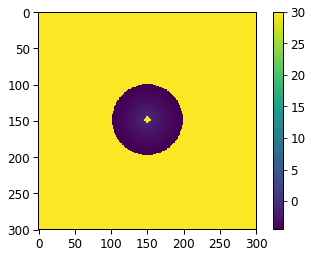

In [41]:
cmb = s.stats['cmb']['mean']
y = s.stats['y']['mean']
scxcmb = s.stats['scxcmb']['mean']
ccxcmb = s.stats['ccxcmb']['mean']
syxy = -s.stats['syxy']['mean']
cyxy = -s.stats['cyxy']['mean']
escxcmb = s.stats['scxcmb']['err']
eccxcmb = s.stats['ccxcmb']['err']
esyxy = s.stats['syxy']['err']
ecyxy = s.stats['cyxy']['err']
sc = s.stats['sc']['mean']
cc = s.stats['cc']['mean']
sy = s.stats['sy']['mean']
cy = s.stats['cy']['mean']

sc_noise = binner.bin(maps.silc_noise(cinv,cresponses))[1]
sy_noise = binner.bin(maps.silc_noise(cinv,yresponses))[1]
cc_noise = binner.bin(maps.cilc_noise(cinv,cresponses,yresponses))[1]
cy_noise = binner.bin(maps.cilc_noise(cinv,yresponses,cresponses))[1]
sn = maps.silc_noise(cinv,cresponses)
sn[sn<-1e30] = -1e30
sn[sn>1e30] = 1e30
print(sn.min(),sn.max())
io.plot_img(np.log10(np.fft.fftshift(sn)))


In [34]:
tt = binner.bin(agen.ps_cmb)[1]

lss,snls = np.loadtxt("/home/msyriac/repos/halofg/data/smica_nls.txt",unpack=True)
lsl,lnls = np.loadtxt("/home/msyriac/repos/halofg/data/lgmca_nls.txt",unpack=True)
snls = snls[lss<3000]
lss = lss[lss<3000]
lnls = lnls[lsl<3000]
lsl = lsl[lsl<3000]


pl = io.Plotter(yscale='log',xlabel='l',ylabel='D')
pl.add(cents,cmb*cents**2.,lw=2,color='k')
pl.add_err(cents,scxcmb*cents**2.,yerr=escxcmb*cents**2,lw=1,label="ilc",marker="o",color="C0")
pl.add_err(cents,ccxcmb*cents**2.,yerr=eccxcmb*cents**2,lw=1,label="cilc",marker="o",color="C1")
pl.add(cents,sc*cents**2.,lw=1,ls="--",color="C0")
pl.add(cents,cc*cents**2.,lw=1,ls="--",color="C1")
pl.add(cents,(sc_noise-tt)*cents**2.,lw=1,ls="-.",color="C0")
pl.add(cents,(cc_noise-tt)*cents**2.,lw=1,ls="-.",color="C1")
pl.add(lss,(snls)*lss**2./maps.gauss_beam(lss,5.)**2.,lw=1,ls="-.",color="C2",label='smica',alpha=0.5)
pl.add(lsl,(lnls)*lsl**2./maps.gauss_beam(lss,5.)**2.,lw=1,ls="-.",color="C3",label='lgmca',alpha=0.5)
pl._ax.set_ylim(1e1,3e4)
pl.legend(loc='lower center')
pl.done("IIcmb.png")

Saved plot to Icmb.png


In [35]:


pl = io.Plotter(yscale='log',xlabel='l',ylabel='D')
#pl = io.Plotter(xlabel='l',ylabel='D')
pl.add(cents,y*cents**2.,lw=2,color='k')
pl.add_err(cents,syxy*cents**2.,yerr=esyxy*cents**2,lw=1,label="ilc",marker="o",color="C0")
pl.add_err(cents,cyxy*cents**2.,yerr=ecyxy*cents**2,lw=1,label="cilc",marker="o",color="C1")
pl.add(cents,sy*cents**2.,lw=1,ls="--",color="C0")
pl.add(cents,cy*cents**2.,lw=1,ls="--",color="C1")
pl.add(cents,sy_noise*cents**2.,lw=1,ls="-.",color="C0")
pl.add(cents,cy_noise*cents**2.,lw=1,ls="-.",color="C1")
#pl.hline()
pl._ax.set_ylim(2e0,2e4)
pl.done("IIy.png")

Saved plot to Iy.png


In [26]:
"""
P 0 to 2000 : 70,100,143,217,353
I 0 to 2000 : ACT + 70,100,143,217,353
II 2000 to 3500 : ACT + 100,143,217,353
III 3500 to 6000 : ACT + 143,217,353
IV 6000 to 20000 : ACT
"""

'\nP 0 to 2000 : 70,100,143,217,353\nI 0 to 2000 : ACT + 70,100,143,217,353\nII 2000 to 3500 : ACT + 100,143,217,353\nIII 3500 to 6000 : ACT + 143,217,353\nIV 6000 to 20000 : ACT\n'